# MOSCOW REAL ESTATE PRICES
**_Doing to houses & apartments what we did to cars_**
### Data Science 410 BB
#### University of Washington Professional & Continuing Education
#### FINAL PROJECT
#### Leo Salemann, 3/10/18

# INTRODUCTION
_An introduction with a statement of the problem you are addressing and a summary of your conclusions.
Is there an introduction with a clear statement of the problem to be addressed? 10%_

_What is our actual purpose?_
- _Identify key features (like aspiration, fuel-type, body-type)._

- _Start with the Kaggle Data_
- _Leverage prior data cleanups via Azure ML Studio_
- _Apply techniques from the autos_

Our dataset comes from a [Kaggle competition to predict real Moscow esate prices](https://www.kaggle.com/c/sberbank-russian-housing-market). I first encountered this data in a [team project](https://www.slideshare.net/LeoSalemann/predicting-moscow-real-estate-prices-with-azure-machine-learning) for [UW PCE Big Data Technologies - Introduciton to Data Engineering](https://www.pce.uw.edu/courses/introduction-to-data-engineering). We used [Microsoft Azure Machine Learning Studio](https://gallery.cortanaintelligence.com/Experiment/D-Hawks-Big-Data-Project-Leo-RevS) to look at multiple approaches to feature engineering, and try multiple machine learning models simultaneosly. For this project, we'll extract realestate data from Azure ML Studio, after cleaning but before any Azure ML modeling.  We'll then do our own feature analysis in Jupyter Notebook with R. Let's get started ...

#### Class Notes
1. start with graphical exploration (violin plots and such)
1. then hypothesis testing (unless too many features) 
   - IN this case, try principal components distribution/analysis, then a scree plot
1. Try ANOVA
1. Try Box Plot

# Selecting a Dataset (Review in ML Studio)
Use Azure ML Studio's *visualize dataset* and histogram & boxplot views
TODO: Add some screenshots.

- **Cleaned**
  - **Histograms** many lef-skewed histograms; prom_part_5000 looks almost like a normal distro.
  - **Box Plots** 
     - build_year has some garbage 20052009 values
     - almost everything has large outliers
- **Cleaned and SQL-Filtered**
  - **Histograms** much better spread
  - **Box Plots** still some outliers, not as bad
- **Cleaned, SQL-Filtered, Normalized**
  - **Histograms**  Some a a little flat and noisy
  - **Box Plots** All of these are clean
  
My favorite dataset is **Cleaned and SQL-Filtered**

# DATA EXPLORATION
_Discussion of your exploration of the dataset supported by charts and summary statistics. Examine several aspects of the dataset. Explain which aspects are important and why._

_Has the data been properly prepared in terms of cleaning, normalization, etc? Is this preparation consistent with the data exploration?_

_Given the data set and the stated problem, does the data exploration find enlightening relationships in the data? Is the exploration truly in-depth? Are the steps used and inferences drawn clearly explained? A few random histograms and scatter plots are not really good enough, the exploration needs to generate insight._

The [original kaggle datasets](https://www.kaggle.com/c/sberbank-russian-housing-market/data) consisted of two tables: Real Estate Transactions and Macro Economics. The Real Estate Transactions table includes price, timestamp, year built, property descriptors such as  square footage, number of floors, condition, etc. and neighborhood descriptors such as nearby transportation, industry, population demographics.  

**_Actually, I didn't use the Macro ecomic data_** The [original kaggle datasets](https://www.kaggle.com/c/sberbank-russian-housing-market/data) consisted of two tables: Real Estate Transactions and Macro Economics. The Real Estate Transactions table includes price, timestamp, year built, property descriptors such as  square footage, number of floors, condition, etc. and neighborhood descriptors such as nearby transportation, industry, population demographics.  The Macro Economics table includes gdb, commodity prices, USD/Ruble exchange rates, etc.

Azure ML Studio Summary
1. Start with the original 30,471 rows and 292 columns
1. Select 64 columns to work with.
1. Set a bunch of numeric data to floating point, integer, category
1. Clean missing data
1. Apply SQL Transofmation (see below)
1. Normalize non-categorical rows


Cleaning missing data

|Field                         |Set To   |Rows Affected|
|------------------------------|---------|-------------|
|build_year                    |1979     |13,605       |
|life_sq (living space, m$^2$) |30       | 6,383       |
|floor (level above ground)    |7        |   167       |
|num_room                      |2        | 9,572       |
|kitch_sq (kitchen space m$^2$)|6        | 9,572       |
|material                      |mode\*   | 9,672       |
|state                         |MICE\*\* |0            |
|full_sq (total m$^2$)         |mode\*   |0            |
|max_floor (highest, 0=ground) |0        | 9,571       |
|metro_min_walk                |median   |    25       |
|railroad_station_walk_km      |median   |    25       |
|railroad_station_walk_min     |median   |    25       |
|metro_km_walk                 |median   |    25       |




\* replace nulls with the mode of the non-null data

\*\* [Multivariate Imputation using Chaned Equations](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/clean-missing-data)

In [1]:
## PROBALBY Skip THE SQL

## Load the data, have a quick look

In [2]:
# real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql_normed.csv")
real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql.csv")
dim(real_estate)
head(real_estate)
str(real_estate)

[1] 15693    64

timestamp             full_sq life_sq floor max_floor material build_year
1 4/27/2013 12:00:00 AM 73      36      17    17        1        1979      
2 5/25/2013 12:00:00 AM 53      30      10    16        1        1980      
3 5/27/2013 12:00:00 AM 41      37      13    17        1        1979      
4 5/27/2013 12:00:00 AM 77      41       2    17        6        2014      
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
  num_room kitch_sq state ⋯ prom_part_2000 office_count_2000 office_sqm_2000
1 2        11       3     ⋯  8.44           0                     0         
2 2         8       3     ⋯ 17.64          10                179554         
3 1         1       1     ⋯  1.45           0                     0         
4 3        12       1     ⋯  1.64           0                     0         
5 2         6       3     ⋯  0.74           0                     0         
6 1         8       3     ⋯ 21.51           4                 31280         
  prom_part_3000 office_count_3000 office_sqm_3000 prom_part_5000
1  8.28           0                     0           6.22         
2 16.69          14                529054          18.47         
3  2.01           0                     0           4.45         
4  1.98           0                     0           4.75         
5  1.99           1                 15000           8.05         
6 18.78          15                136990          11.12         
  office_count_5000 office_sqm_5000 price_doc
1  2                 138650         10100000 
2 25                 766701          9000000 
3  0                      0          4457400 
4  0                      0          7011550 
5  3                  81947          7100000 
6 83                3903973          6450000

'data.frame':	15693 obs. of  64 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 335 382 387 387 387 390 390 395 416 464 ...
 $ full_sq                          : int  73 53 41 77 45 38 63 74 51 77 ...
 $ life_sq                          : int  36 30 37 41 27 20 30 46 30 50 ...
 $ floor                            : int  17 10 13 2 6 15 17 12 7 3 ...
 $ max_floor                        : int  17 16 17 17 9 16 17 24 17 5 ...
 $ material                         : int  1 1 1 6 1 1 4 1 1 2 ...
 $ build_year                       : int  1979 1980 1979 2014 1970 1982 2013 2004 2003 1957 ...
 $ num_room                         : int  2 2 1 3 2 1 2 3 2 3 ...
 $ kitch_sq                         : int  11 8 1 12 6 8 1 9 9 8 ...
 $ state                            : int  3 3 1 1 3 3 1 3 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 2 1 1 2 1 1 1 ...
 $ sub_area                         : Factor 

In [3]:
real_estate = na.omit(real_estate)
dim(real_estate)
head(real_estate)
str(real_estate)

[1] 9233   64

timestamp             full_sq life_sq floor max_floor material build_year
5  5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6  5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7  5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
8  5/30/2013 12:00:00 AM 74      46      12    24        1        2004      
9  6/1/2013 12:00:00 AM  51      30       7    17        1        2003      
10 6/3/2013 12:00:00 AM  77      50       3     5        2        1957      
   num_room kitch_sq state ⋯ prom_part_2000 office_count_2000 office_sqm_2000
5  2        6        3     ⋯  0.74           0                      0        
6  1        8        3     ⋯ 21.51           4                  31280        
7  2        1        1     ⋯ 26.61           0                      0        
8  3        9        3     ⋯ 18.95           6                 108184        
9  2        9        3     ⋯ 24.09           1                 104000        
10 3        8        2     ⋯ 17.48          68                1849285        
   prom_part_3000 office_count_3000 office_sqm_3000 prom_part_5000
5   1.99            1                 15000          8.05         
6  18.78           15                136990         11.12         
7  13.06            0                     0          6.54         
8  10.98            8                115507         12.31         
9  18.74            3                183000         13.57         
10 14.22          145               3353936         14.54         
   office_count_5000 office_sqm_5000 price_doc
5    3                 81947          7100000 
6   83               3903973          6450000 
7    1                 26950          5903808 
8   30                651686         12100000 
9   11                385012          7700000 
10 426               6956461         11700000

'data.frame':	9233 obs. of  64 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

## _Date Time Practice_

In [4]:
dtimes = c("2002-06-09 12:45:40 AM","2003-01-29 09:30:40 AM",
            "2002-09-04 16:45:40 AM","2002-11-13 20:00:40 AM",
            "2002-07-07 17:30:40 AM")
dtimes

[1] "2002-06-09 12:45:40 AM" "2003-01-29 09:30:40 AM" "2002-09-04 16:45:40 AM"
[4] "2002-11-13 20:00:40 AM" "2002-07-07 17:30:40 AM"

In [5]:
dtimes = as.data.frame(c("6/9/2002 12:45:40 AM","1/29/2003 09:30:40 AM",
           "9/4/2002 16:45:40 AM","11/13/2002 20:00:40 AM",
           "7/7/2002 17:30:40 AM"))
colnames(dtimes) = c("timestamp")
dtimes

timestamp             
1 6/9/2002 12:45:40 AM  
2 1/29/2003 09:30:40 AM 
3 9/4/2002 16:45:40 AM  
4 11/13/2002 20:00:40 AM
5 7/7/2002 17:30:40 AM

In [6]:
dtimes[,1]

[1] 6/9/2002 12:45:40 AM   1/29/2003 09:30:40 AM  9/4/2002 16:45:40 AM  
[4] 11/13/2002 20:00:40 AM 7/7/2002 17:30:40 AM  
5 Levels: 11/13/2002 20:00:40 AM ... 9/4/2002 16:45:40 AM

In [7]:
dtimes$date = as.Date(dtimes[,1],format='%m/%d/%Y')
dtimes
str(dtimes)

timestamp              date      
1 6/9/2002 12:45:40 AM   2002-06-09
2 1/29/2003 09:30:40 AM  2003-01-29
3 9/4/2002 16:45:40 AM   2002-09-04
4 11/13/2002 20:00:40 AM 2002-11-13
5 7/7/2002 17:30:40 AM   2002-07-07

'data.frame':	5 obs. of  2 variables:
 $ timestamp: Factor w/ 5 levels "11/13/2002 20:00:40 AM",..: 3 2 5 1 4
 $ date     : Date, format: "2002-06-09" "2003-01-29" ...


## Add Date to supplement timestamp

In [8]:
dtimes$date = as.Date(dtimes[,1],format='%m/%d/%Y')

## Add Price Per Square Meter & Parse the date

In [9]:
real_estate$price_sqm = real_estate$price_doc/real_estate$full_sq
real_estate$date = as.Date(real_estate$timestamp,format='%m/%d/%Y')
head(real_estate,3)
str(real_estate)

timestamp             full_sq life_sq floor max_floor material build_year
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7 5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
  num_room kitch_sq state ⋯ office_sqm_2000 prom_part_3000 office_count_3000
5 2        6        3     ⋯     0            1.99           1               
6 1        8        3     ⋯ 31280           18.78          15               
7 2        1        1     ⋯     0           13.06           0               
  office_sqm_3000 prom_part_5000 office_count_5000 office_sqm_5000 price_doc
5  15000           8.05           3                  81947         7100000  
6 136990          11.12          83                3903973         6450000  
7      0           6.54           1                  26950         5903808  
  price_sqm date      
5 157777.78 2013-05-27
6 169736.84 2013-05-28
7  93711.24 2013-05-28

'data.frame':	9233 obs. of  66 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

## Density plot of price

Loading required package: ggplot2


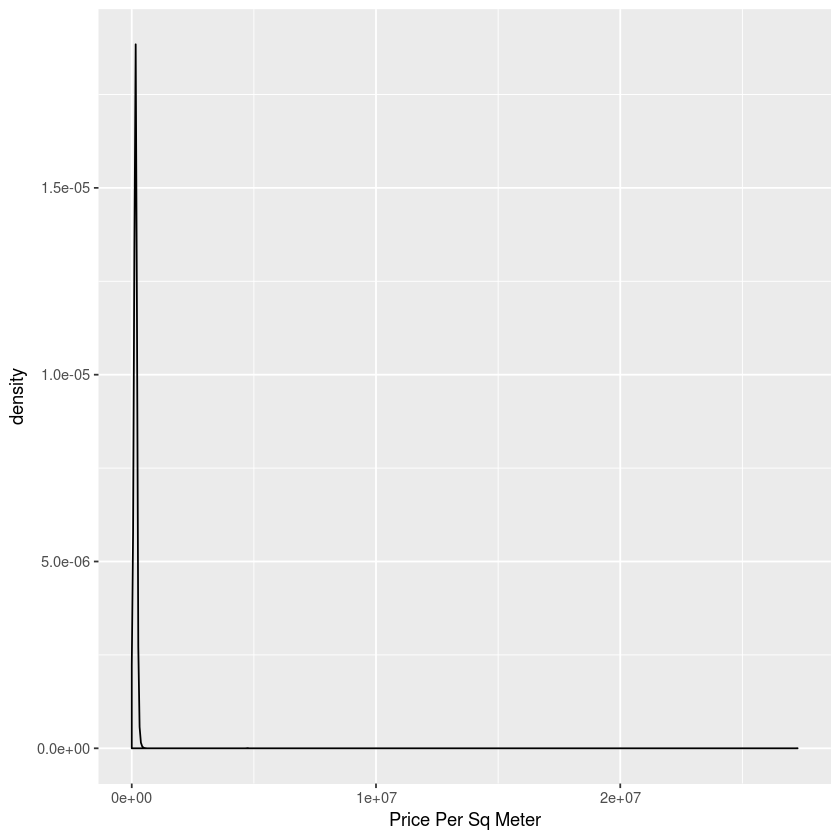

In [10]:
require(ggplot2)
ggplot(real_estate, aes(price_sqm)) + geom_density() + xlab('Price Per Sq Meter')

timestamp             full_sq life_sq floor max_floor material build_year
5  5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6  5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7  5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
8  5/30/2013 12:00:00 AM 74      46      12    24        1        2004      
9  6/1/2013 12:00:00 AM  51      30       7    17        1        2003      
10 6/3/2013 12:00:00 AM  77      50       3     5        2        1957      
   num_room kitch_sq state ⋯ prom_part_3000 office_count_3000 office_sqm_3000
5  2        6        3     ⋯  1.99            1                 15000        
6  1        8        3     ⋯ 18.78           15                136990        
7  2        1        1     ⋯ 13.06            0                     0        
8  3        9        3     ⋯ 10.98            8                115507        
9  2        9        3     ⋯ 18.74            3                183000        
10 3        8        2     ⋯ 14.22          145               3353936        
   prom_part_5000 office_count_5000 office_sqm_5000 price_doc price_sqm
5   8.05            3                 81947          7100000  157777.78
6  11.12           83               3903973          6450000  169736.84
7   6.54            1                 26950          5903808   93711.24
8  12.31           30                651686         12100000  163513.51
9  13.57           11                385012          7700000  150980.39
10 14.54          426               6956461         11700000  151948.05
   date       log.price_sqm
5  2013-05-27 11.96894     
6  2013-05-28 12.04200     
7  2013-05-28 11.44797     
8  2013-05-30 12.00465     
9  2013-06-01 11.92491     
10 2013-06-03 11.93129

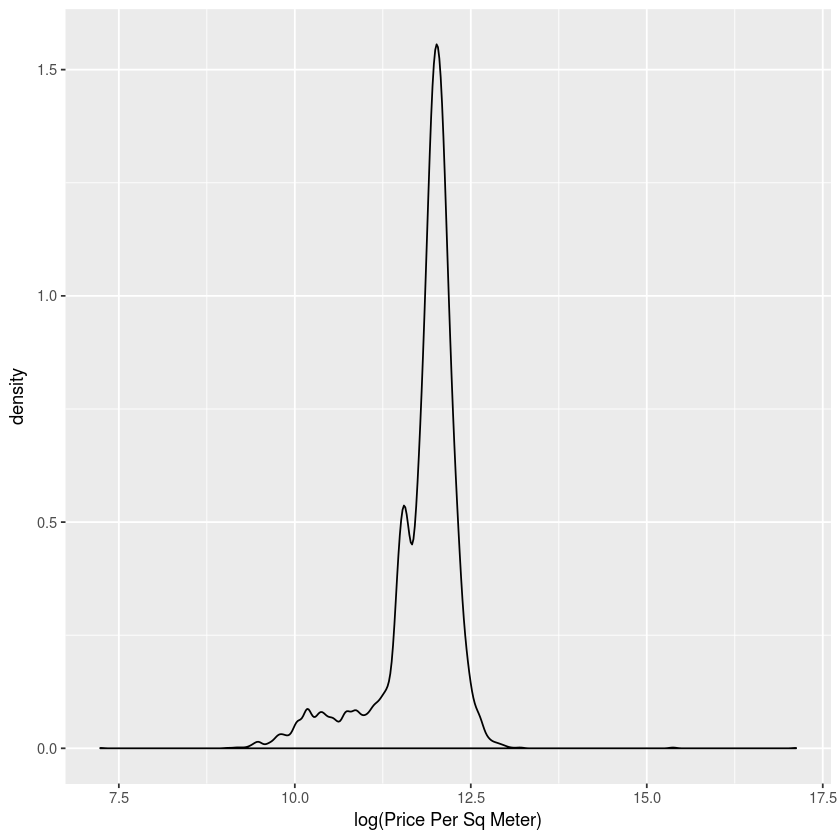

In [11]:
real_estate$log.price_sqm = log(real_estate$price_sqm)
head(real_estate)
ggplot(real_estate, aes(log.price_sqm)) + geom_density() + 
xlab('log(Price Per Sq Meter)')

Warning message:
“Removed 11 rows containing non-finite values (stat_density).”

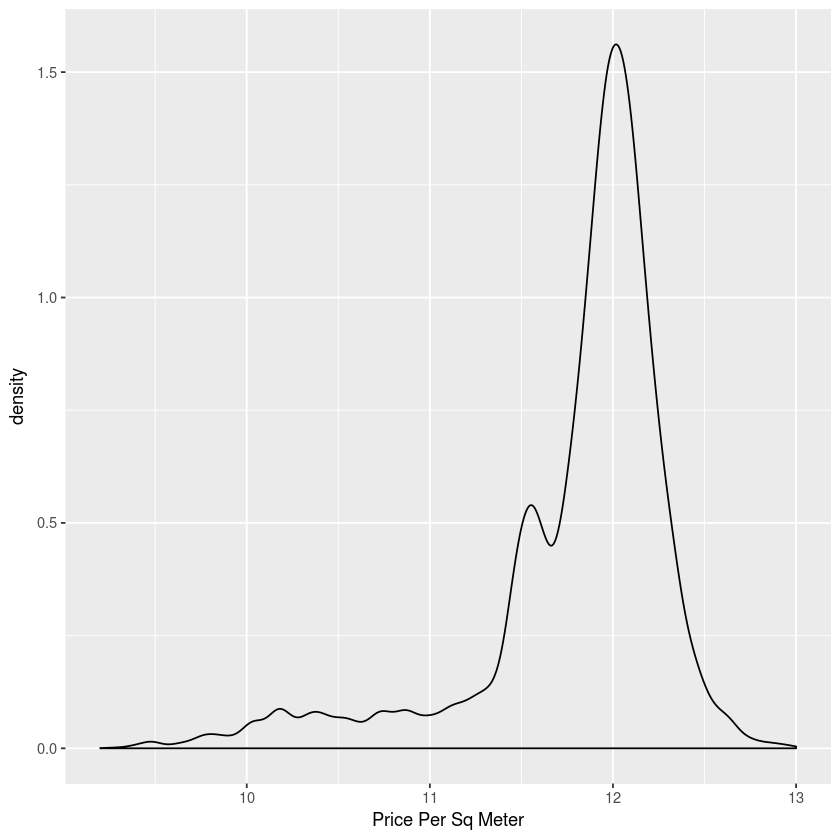

In [12]:
# For cleaned, sql'ed, normalized
x_min = 9.2
x_max = 13

ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter') + 
xlim(c(x_min, x_max)) 

In [13]:
real_estate.trimmed = real_estate[real_estate$log.price_sqm <= x_max,]
real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$log.price_sqm >= x_min,]
real_estate = real_estate.trimmed
dim(real_estate)

[1] 9222   67

In [14]:
dim(real_estate)
str(real_estate)

[1] 9222   67

'data.frame':	9222 obs. of  67 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

Loading required package: car


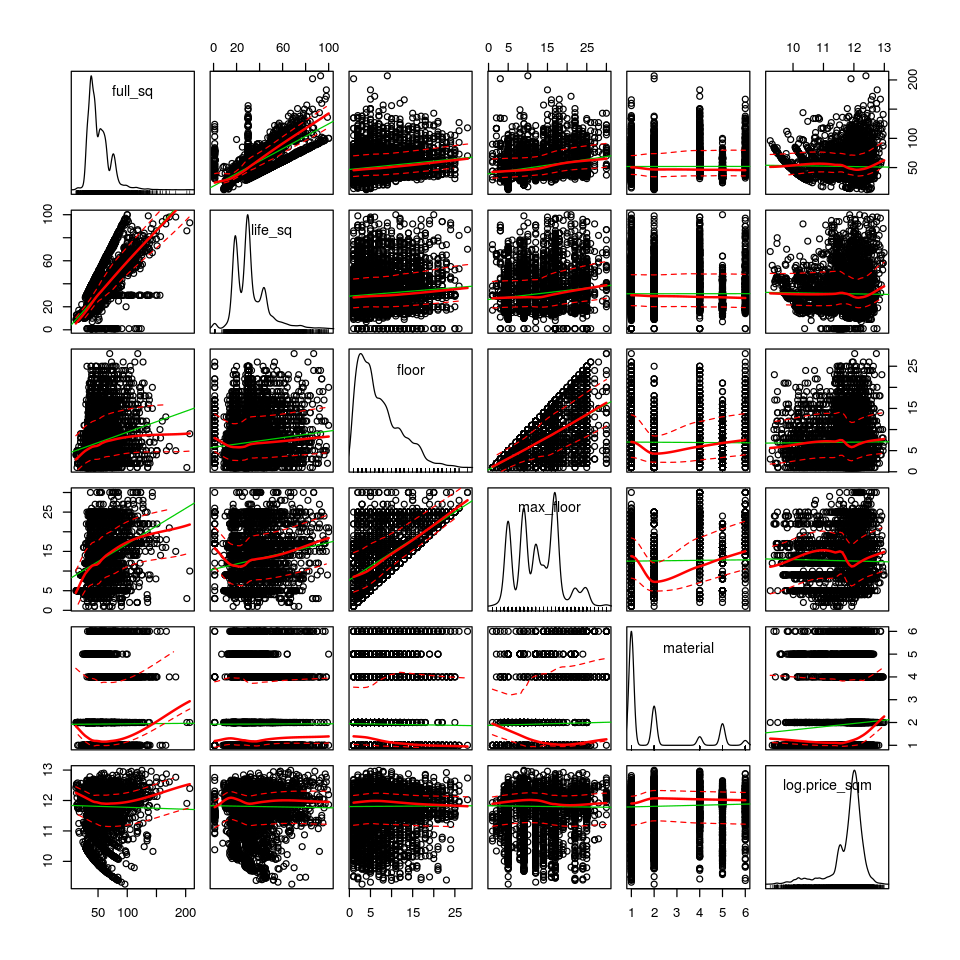

In [15]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  full_sq +
                  life_sq +
                  floor +
                  max_floor +
                  material +
                  log.price_sqm,
                  data = real_estate)

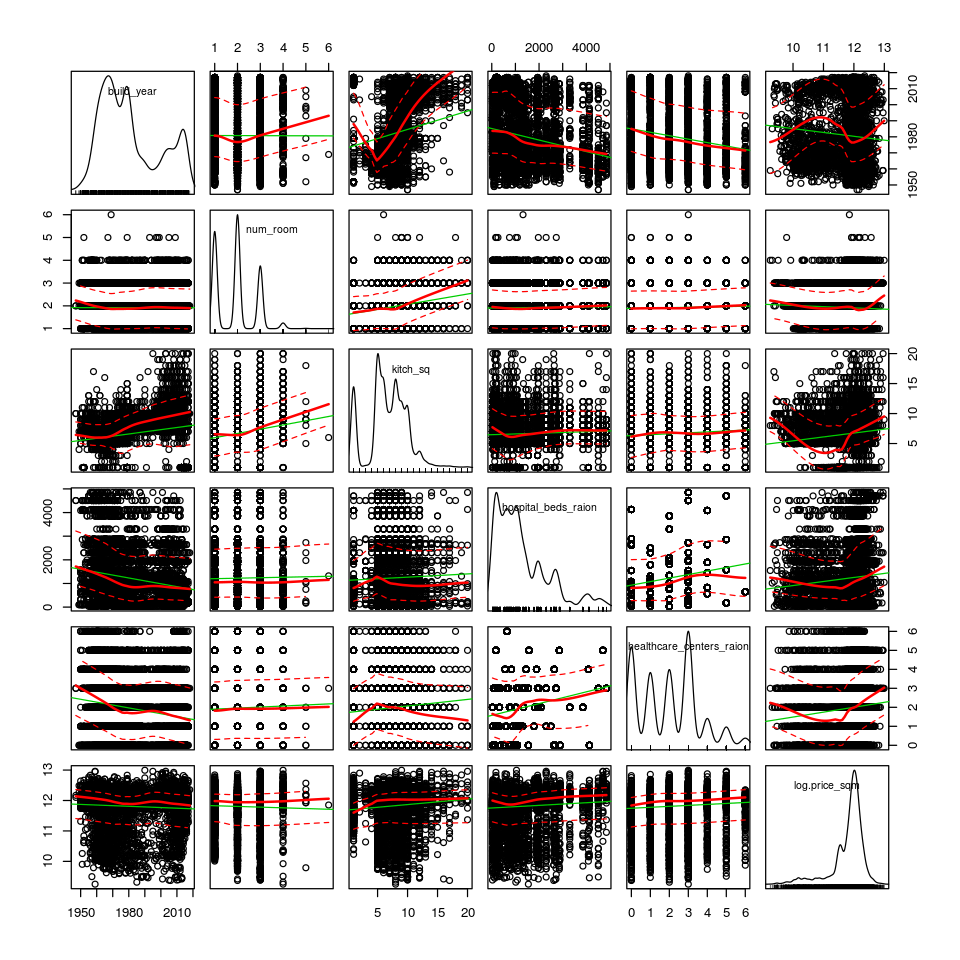

In [16]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  build_year +
                  num_room +
                  kitch_sq +
                  hospital_beds_raion +
                  healthcare_centers_raion +
                  log.price_sqm,
                  data = real_estate)

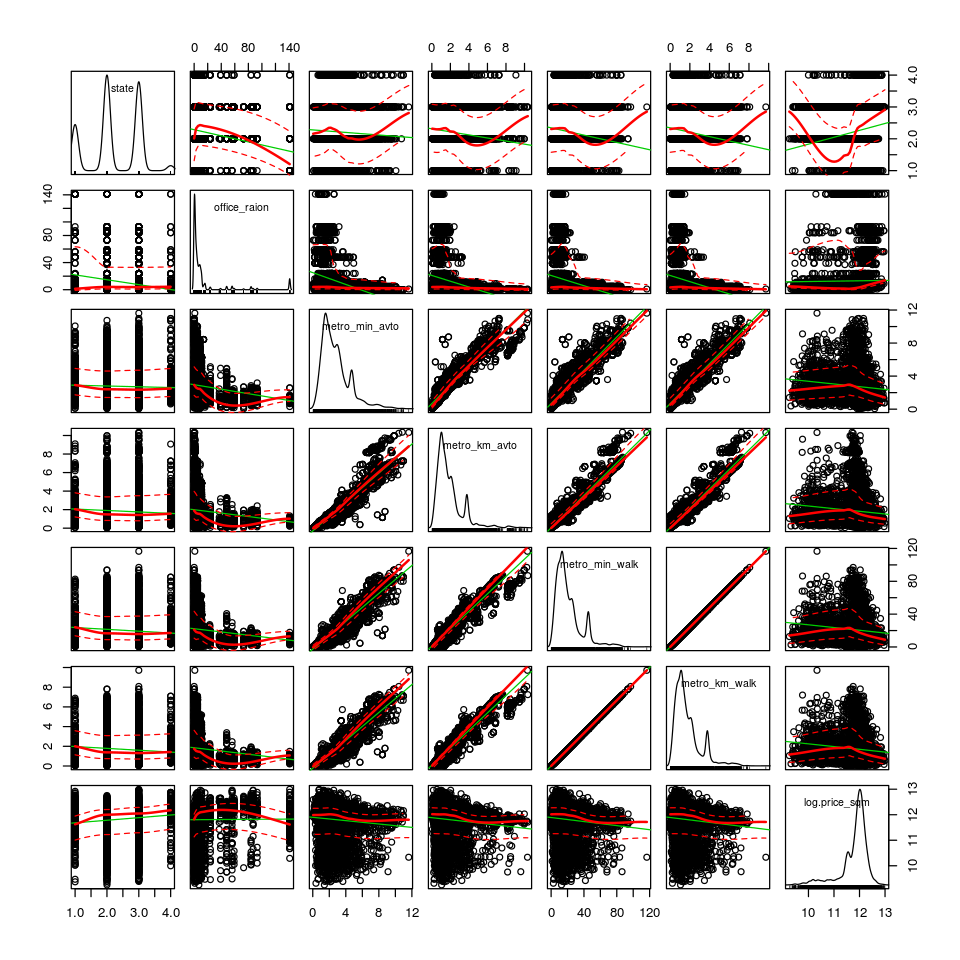

In [17]:
scatterplotMatrix(~ 
                 state +
                  office_raion   +
                  metro_min_avto +
                  metro_km_avto  +
                  metro_min_walk +
                  metro_km_walk +
                  log.price_sqm,
                  data = real_estate)

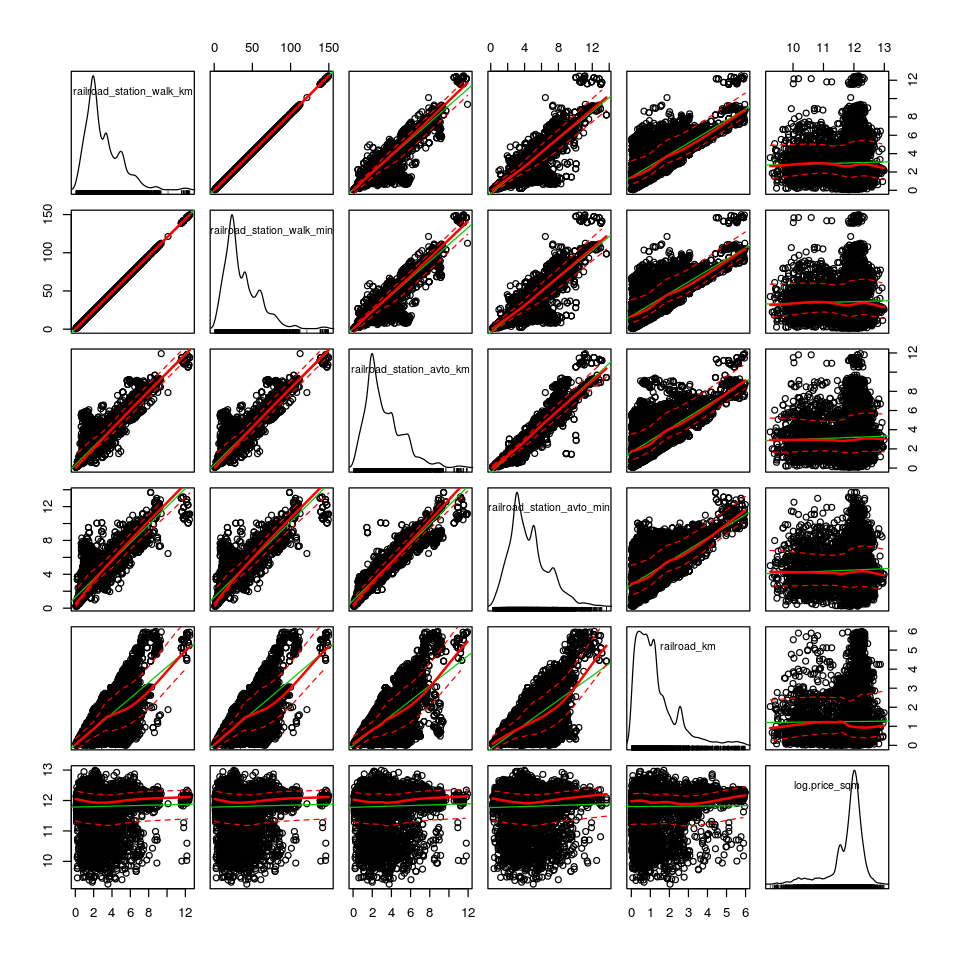

In [18]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                    railroad_station_walk_km          +
                    railroad_station_walk_min         +
                    railroad_station_avto_km          +
                    railroad_station_avto_min         +
                   railroad_km                      +
                  log.price_sqm,
                  data = real_estate)

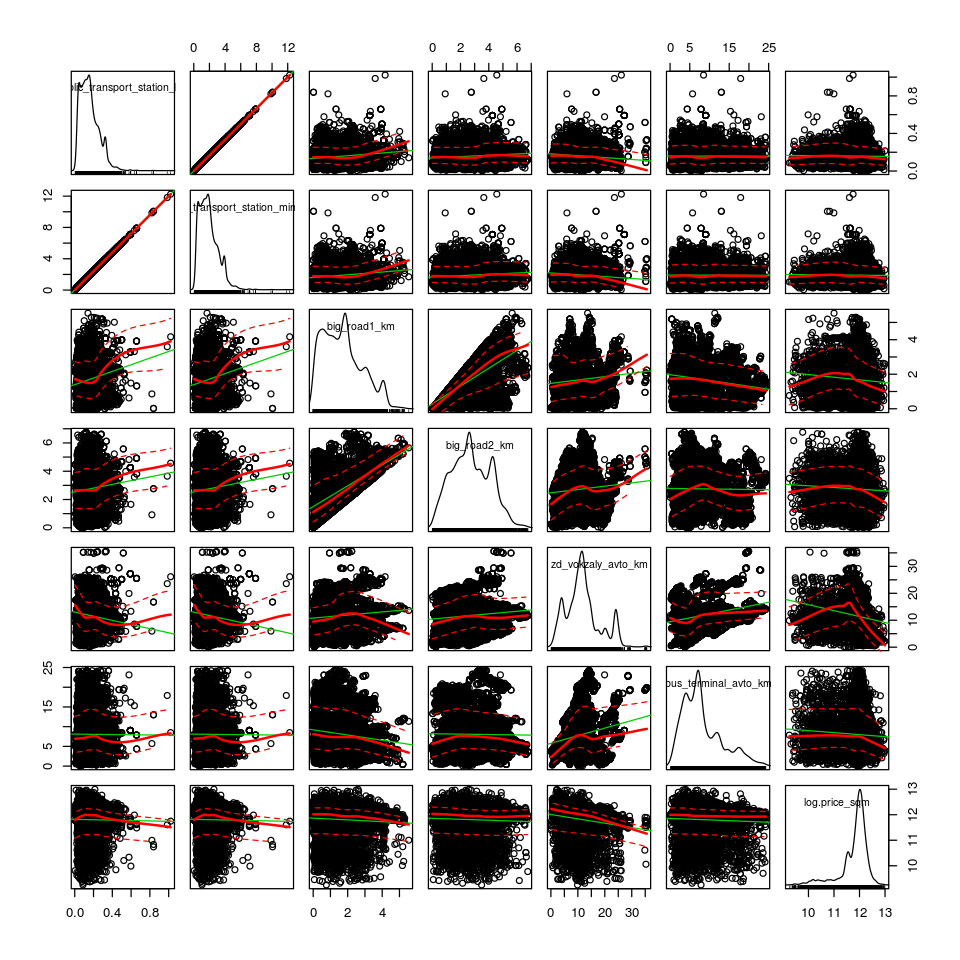

In [19]:
scatterplotMatrix(~ 
                public_transport_station_km       +
                public_transport_station_min_walk +
                big_road1_km                     +
                big_road2_km                     +
                zd_vokzaly_avto_km               +
                bus_terminal_avto_km             +
                  log.price_sqm,
                  data = real_estate)

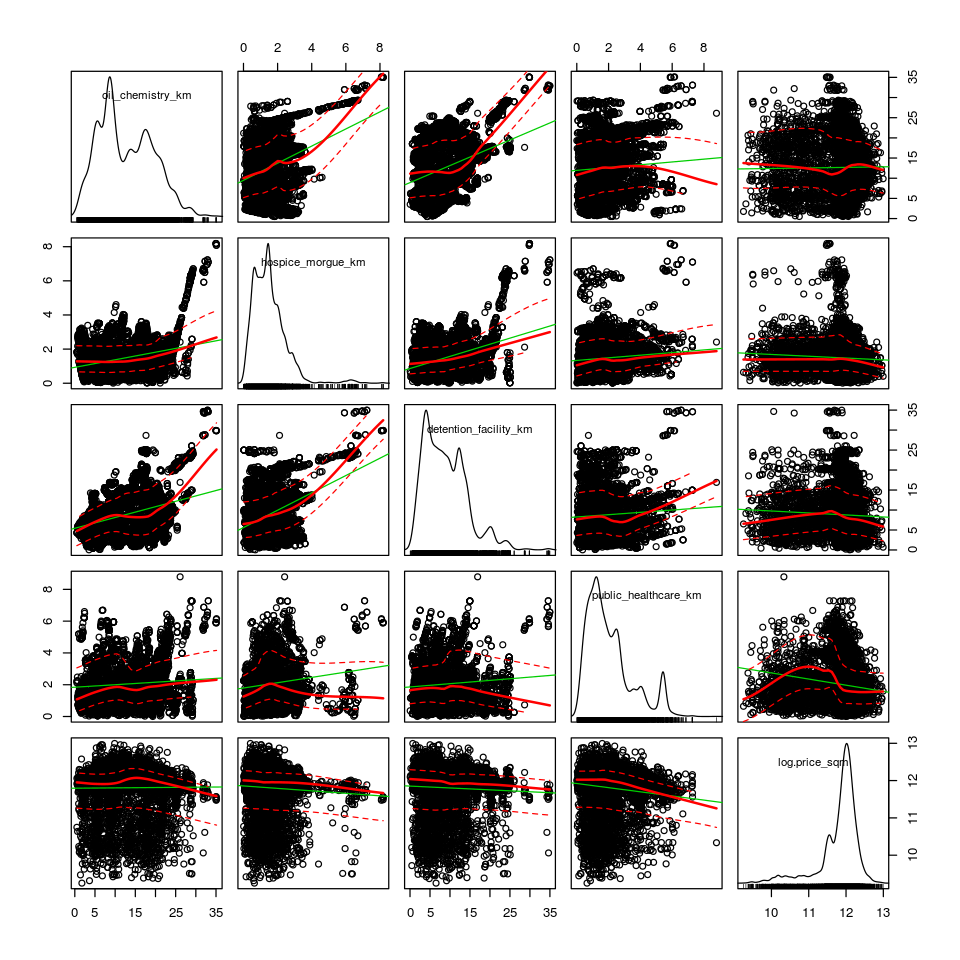

In [20]:
scatterplotMatrix(~ 
                oil_chemistry_km                 +
                hospice_morgue_km                +
                detention_facility_km            +
                public_healthcare_km             +
                  log.price_sqm,
                  data = real_estate)

Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”

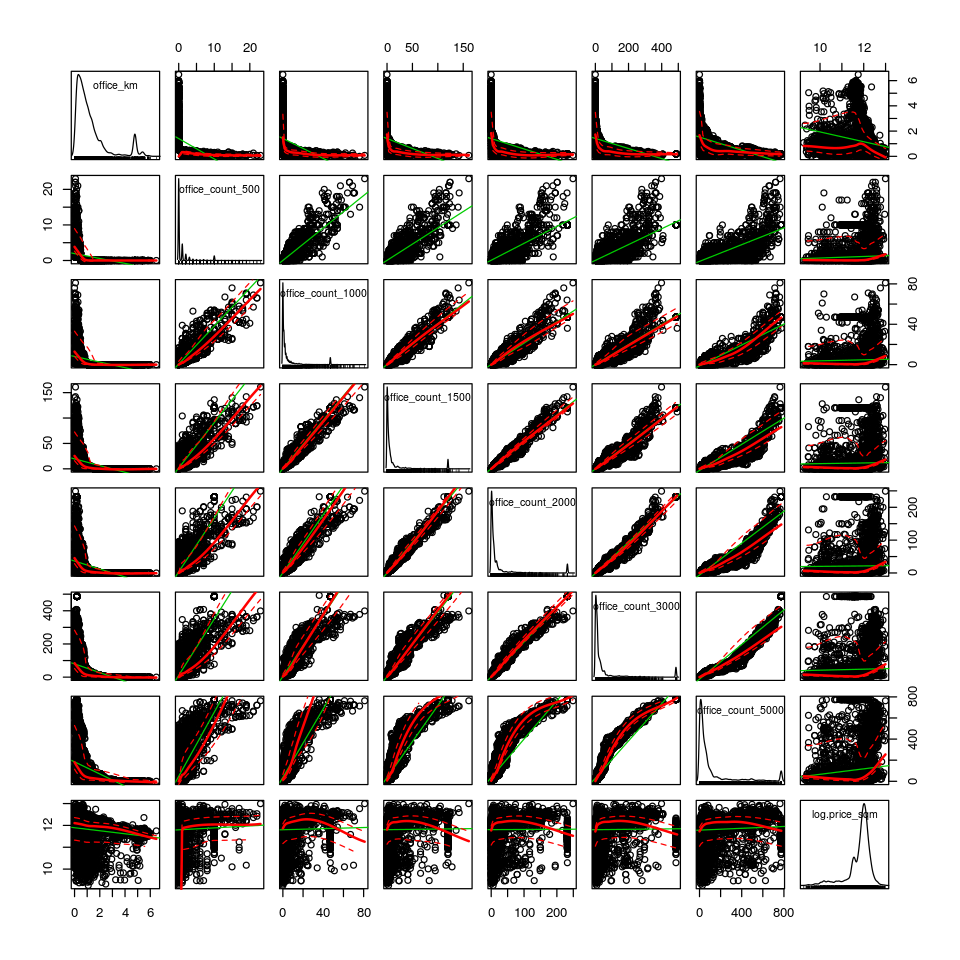

In [21]:
scatterplotMatrix(~ 
                office_km                        +
                office_count_500                 +
                office_count_1000                +
                office_count_1500                +
                office_count_2000                +
                office_count_3000                +
                office_count_5000                +
                  log.price_sqm,
                  data = real_estate)

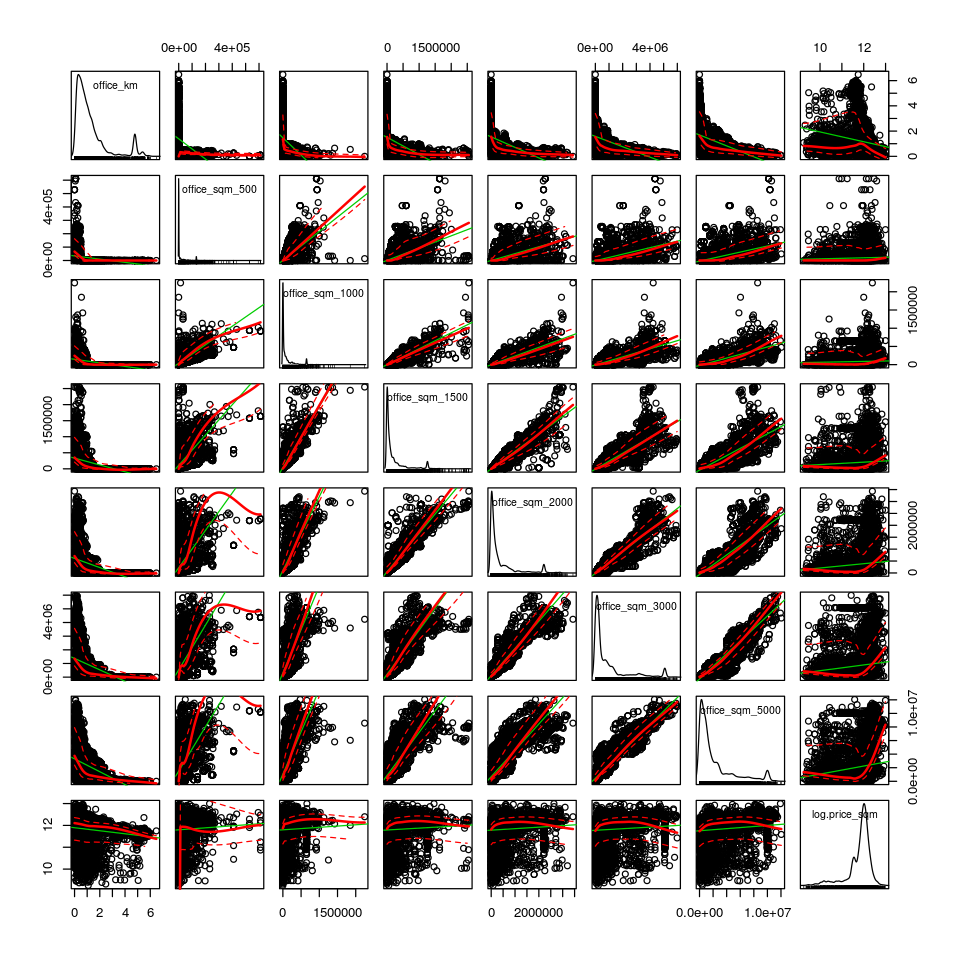

In [22]:
scatterplotMatrix(~ 
                office_km                        +
                office_sqm_500                   +
                office_sqm_1000                  +
                office_sqm_1500                  +
                office_sqm_2000                  +
                office_sqm_3000                  +
                office_sqm_5000                  + 

                  log.price_sqm,
                  data = real_estate)

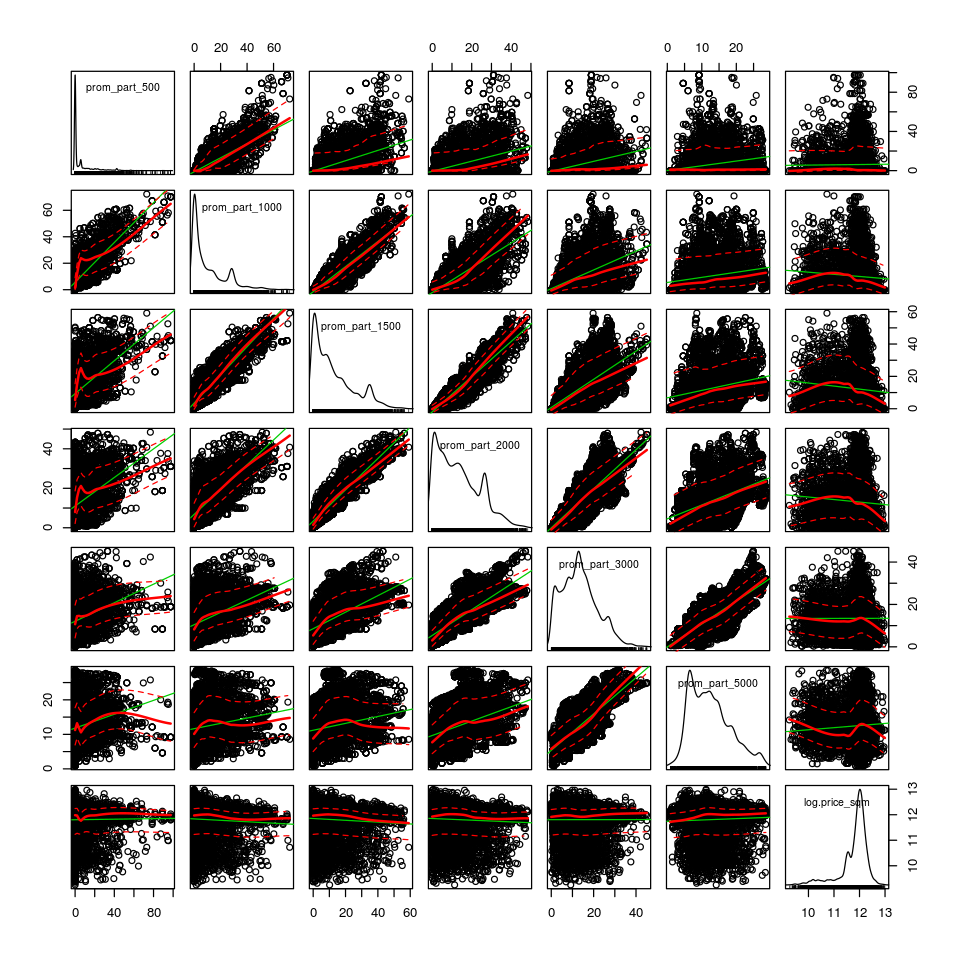

In [23]:
scatterplotMatrix(~ 
                  prom_part_500                    +
                  prom_part_1000                   +
                  prom_part_1500                   +
                  prom_part_2000                   +
                  prom_part_3000                   +
                  prom_part_5000                   +

                  log.price_sqm,
                  data = real_estate)

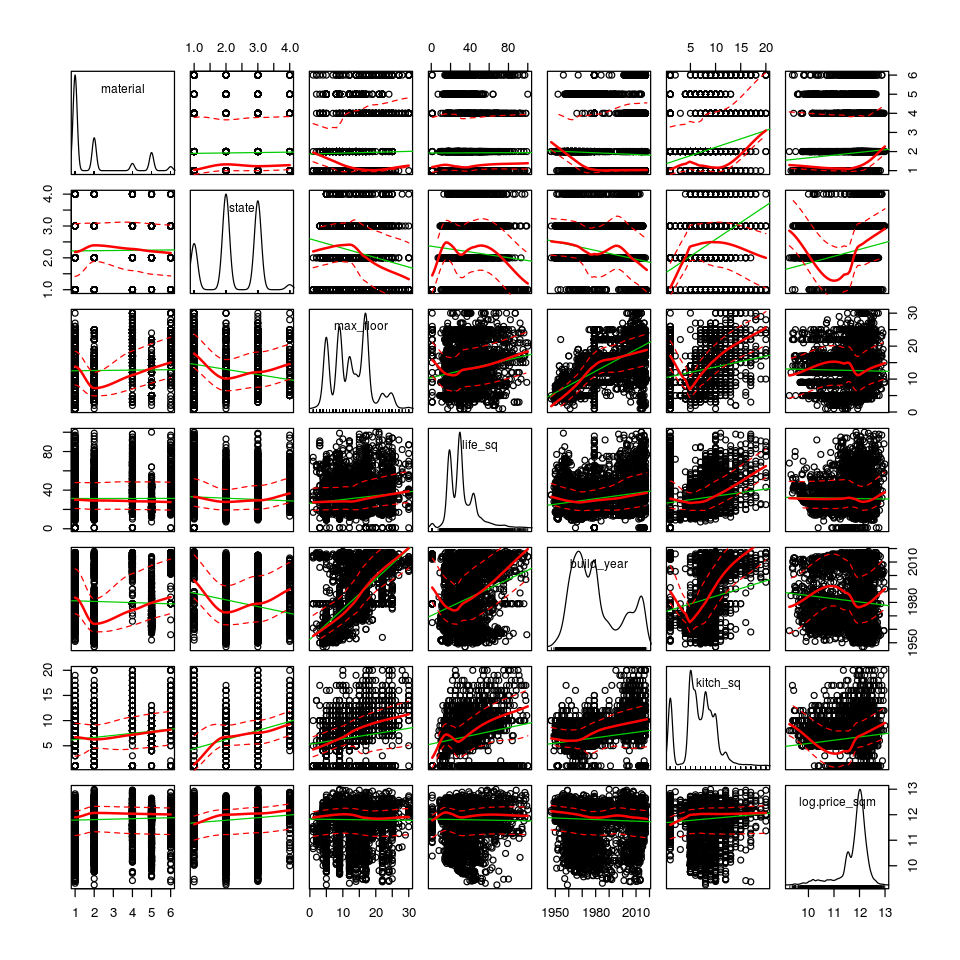

In [26]:
scatterplotMatrix(~ 
                    material  +
                    state  +
                    max_floor  +
                    life_sq  +
                    build_year  +
                    kitch_sq      +              
                  log.price_sqm,
                  data = real_estate)

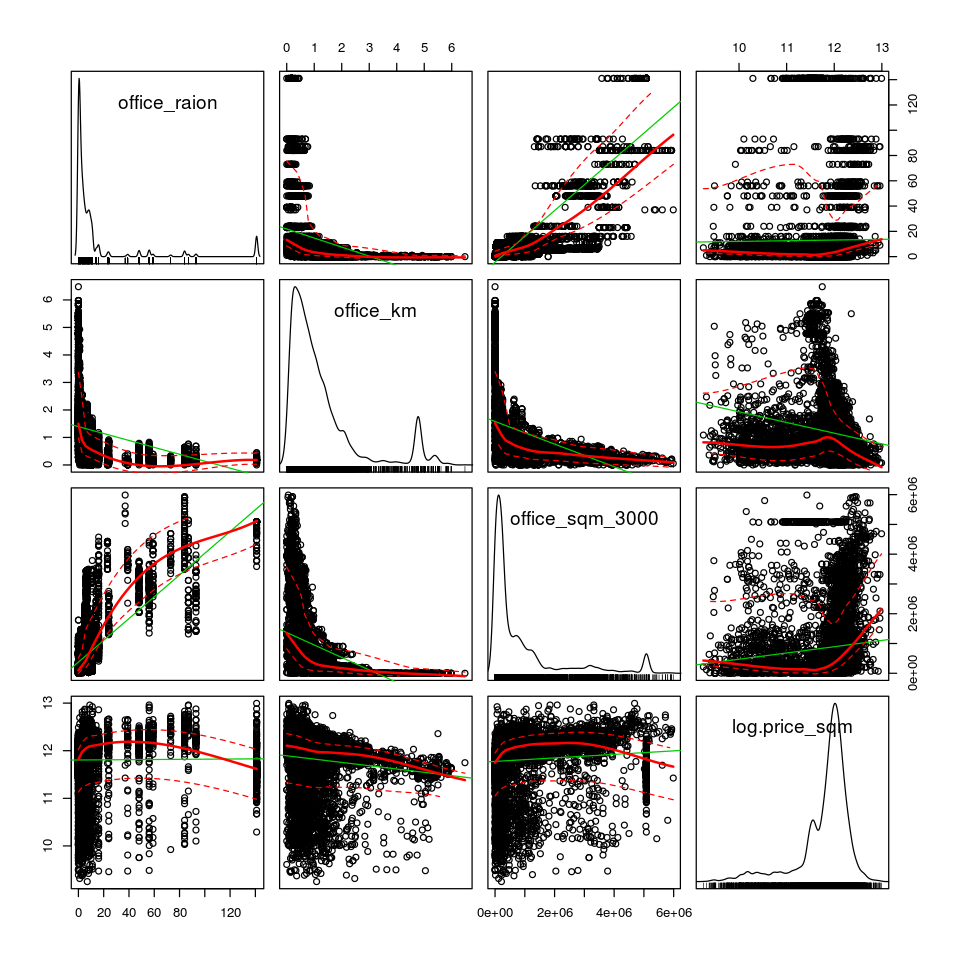

In [27]:
scatterplotMatrix(~ 
                 office_raion + 
                 office_km +
                 office_sqm_3000 +
                  log.price_sqm,
                  data = real_estate)

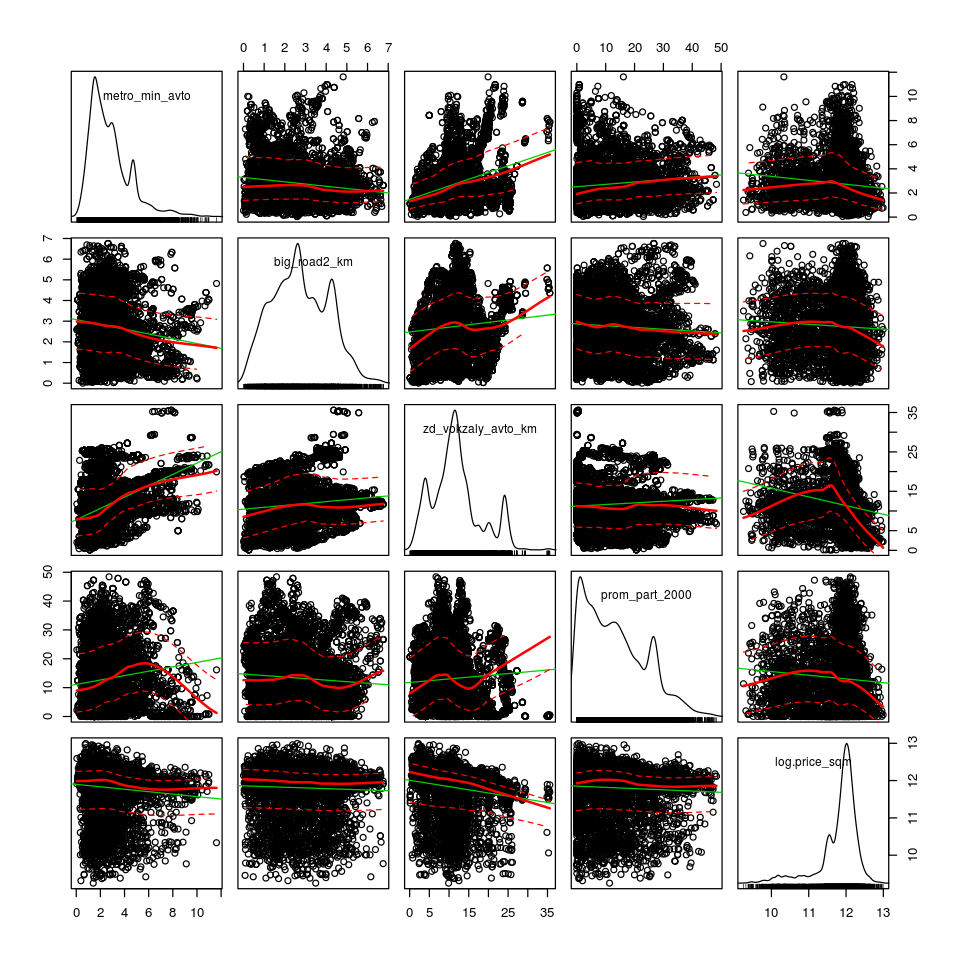

In [28]:
scatterplotMatrix(~ 
                 metro_min_avto +
                 big_road2_km +
                 zd_vokzaly_avto_km +
                 prom_part_2000 +
                  log.price_sqm, 
                  data = real_estate)

**scatterplotMatrix Notes**
- possible categoricals
  - material  
  - state 

- possible params
  - max_floor 
  - life_sq
  - build_year
  - kitch_sq
  
  - office_raion 
  - office_km 
  - office_sqm_3000
  
  - metro_min_avto 
  - big_road2_km 
  - zd_vokzaly_avto_km 
  - prom_part_2000 

In [ ]:
## Color plots

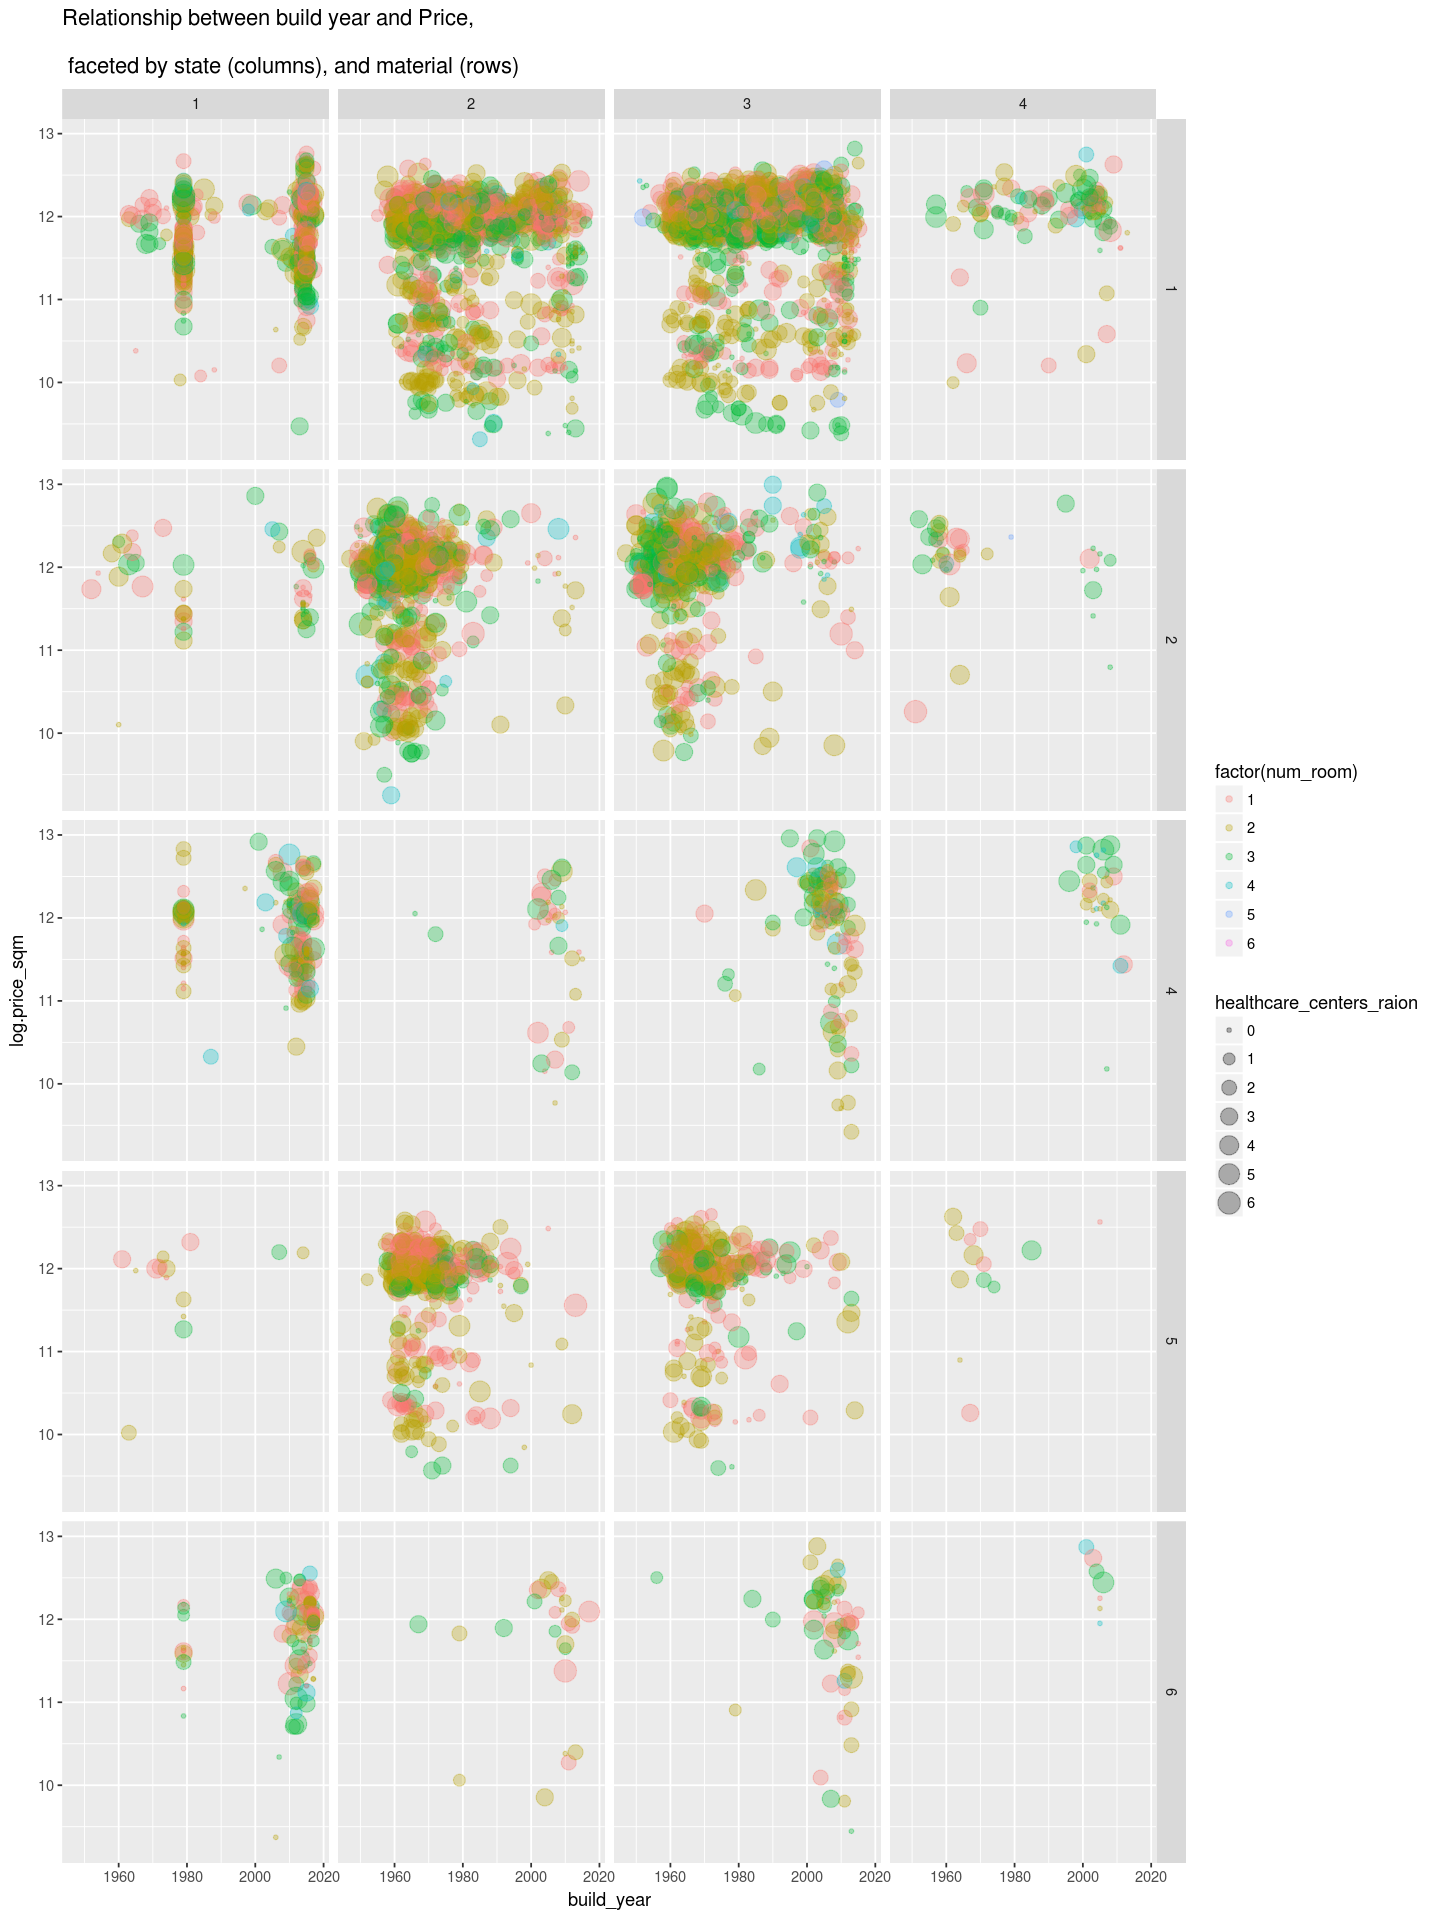

In [44]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(build_year, log.price_sqm)) +
facet_grid(material ~ state) +
geom_point(aes(color = factor(num_room), 
           size = healthcare_centers_raion), alpha = 0.3) +
ggtitle('Relationship between build year and Price, 
  \n faceted by state (columns), and material (rows)')

In [ ]:
## Possible ways to split things (like autos/fuel/body...)
- Build year before/after 2000
- material

** Try out bootstrapped difference of means**

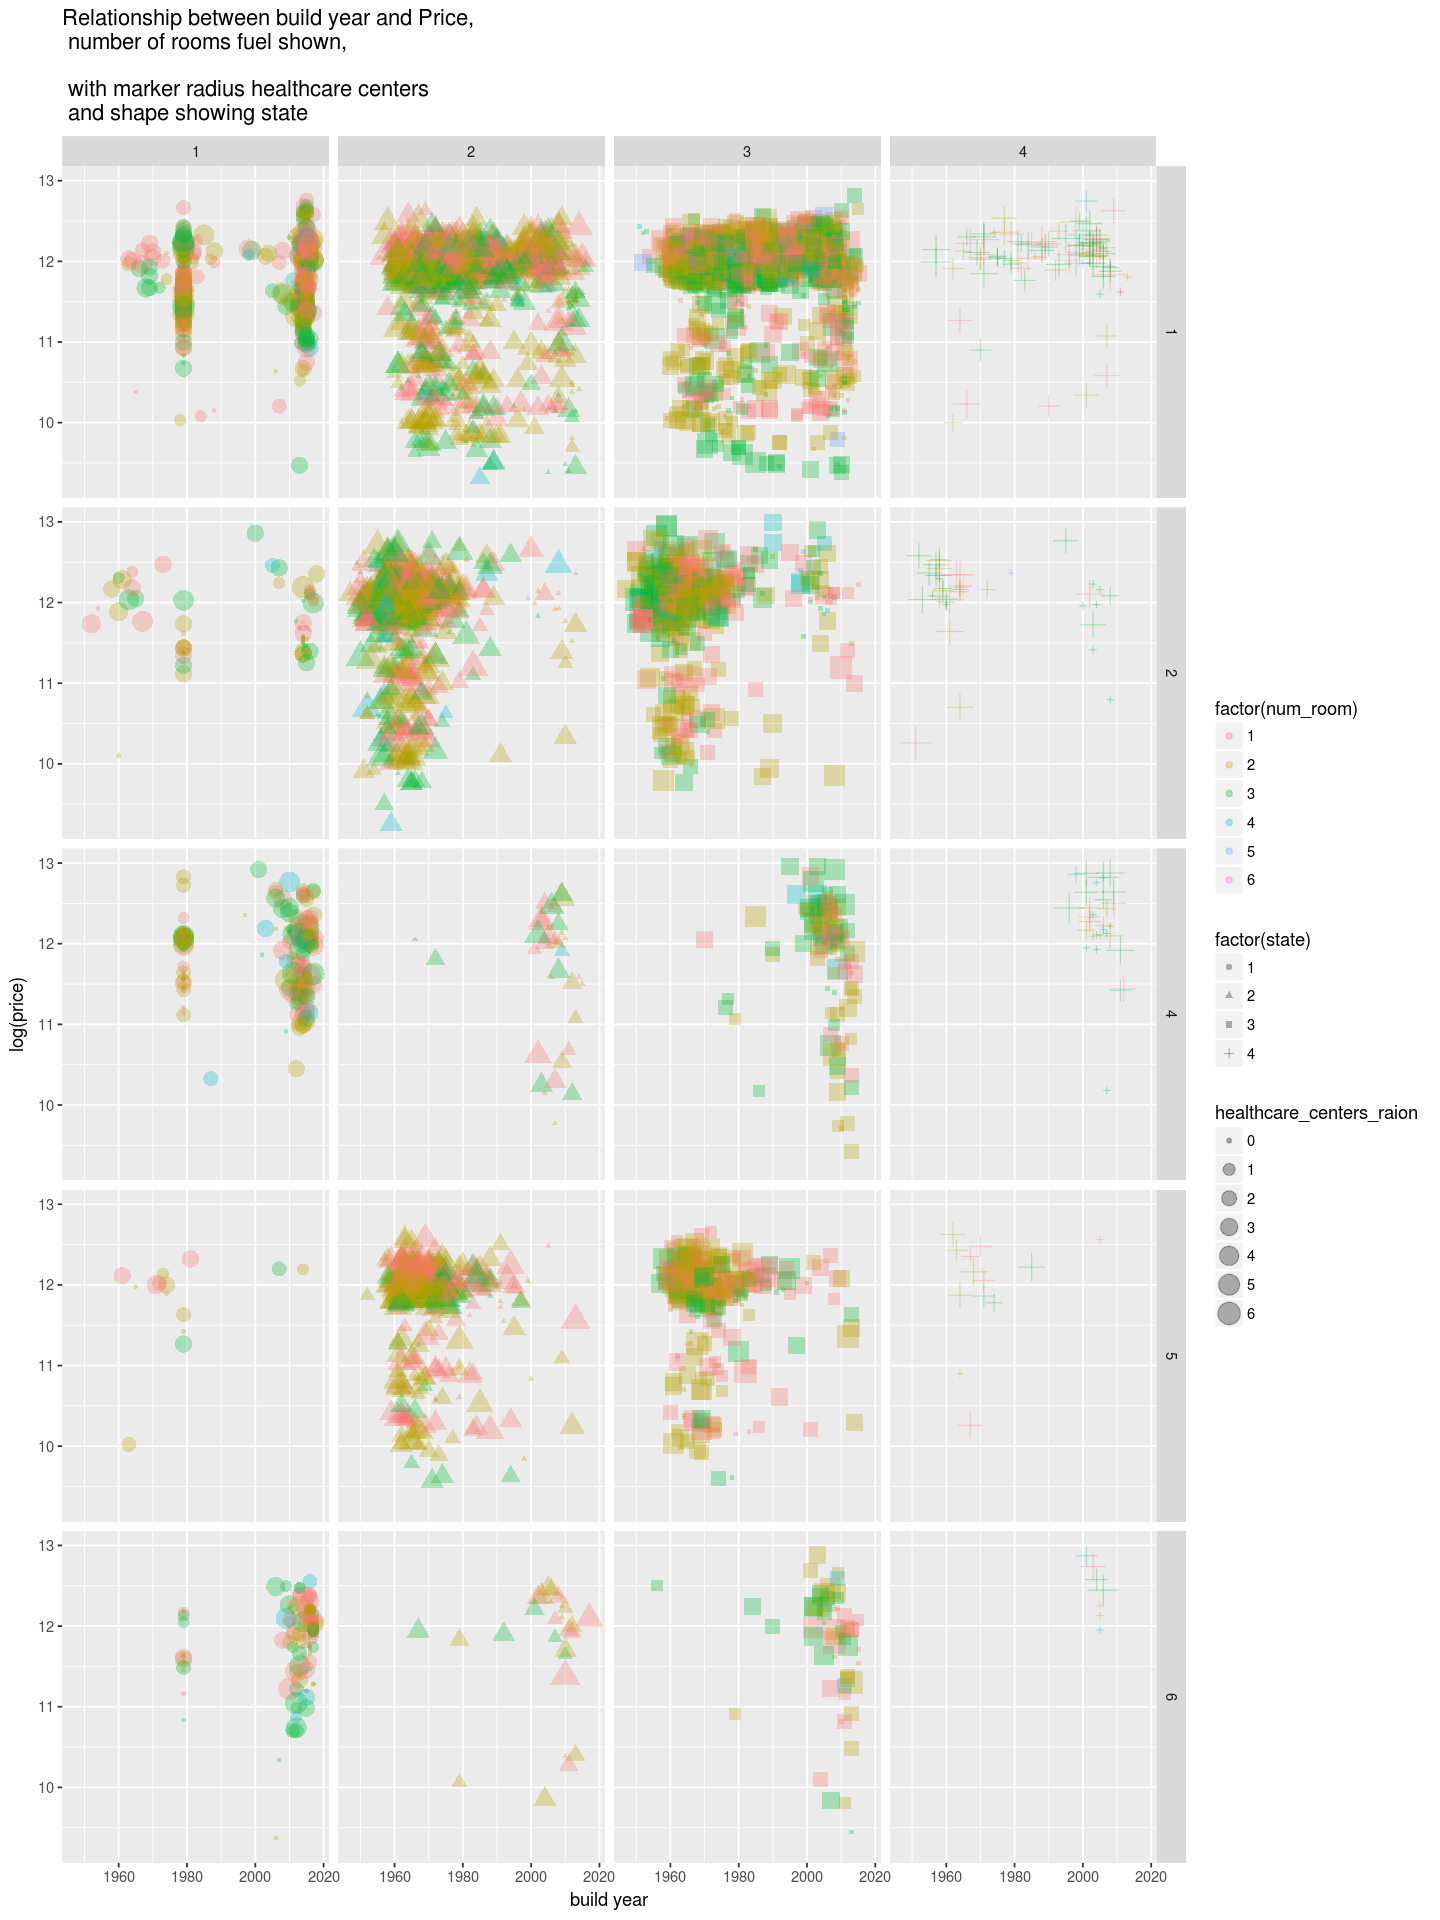

In [38]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(build_year, log.price_sqm)) + 
geom_point(aes(color = factor(num_room), shape = factor(state), 
           size = healthcare_centers_raion), alpha = 0.3) + 
facet_grid(material ~ state) +
xlab('build year') + ylab('log(price)') + 
ggtitle('Relationship between build year and Price, \n number of rooms fuel shown, 
  \n with marker radius healthcare centers \n and shape showing state')

In [ ]:
# For cleaned, sql'ed, normalized
x_min = 12
x_max = 29
y_min = 0
y_max = 1.1

In [ ]:
ggplot(real_estate, aes(x = log.price_sqm, y = full_sq,))+ 
geom_point(aes(color = factor(state),
               size = date),
               alpha = 0.3) + 
xlim(c(x_min, x_max)) + ylim(c(y_min, y_max)) + 
geom_density2d() +
xlab('log(Price Per Sq Meter)') + 
ylab('Foor space') + 
ggtitle('Price and Floor Space')

In [ ]:
head(real_estate)

In [ ]:
head(real_estate$log.price_sqm)

From [stack overvlow](https://stackoverflow.com/questions/19483415/subset-a-dataframe-by-multiple-factor-levels)

In [ ]:
# real_estate.trimmed = real_estate[real_estate$log.price_sqm %in% 8.0:14.0]
# real_estate = real_estate[real_estate$full_sq %in% 10:250]
# real_estate.trimmed = with(real_estate, log.price_sqm <= 14.0 & log.price_sqm >= 8.0)
dim(real_estate)
real_estate.trimmed = real_estate[real_estate$log.price_sqm <= x_max,]
dim(real_estate.trimmed)

real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$log.price_sqm >= x_min,]
dim(real_estate.trimmed)

real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$full_sq <= y_max,]
dim(real_estate.trimmed)

real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$full_sq >= y_min,]
dim(real_estate.trimmed)

head(real_estate.trimmed,3)
dim(real_estate)
dim(real_estate.trimmed)
real_estate = real_estate.trimmed

In [ ]:
ggplot(real_estate, aes(x = log.price_sqm, y = full_sq,))+ 
geom_point(aes(color = factor(state),
               size = date),
               alpha = 0.3) + 
geom_density2d() +
xlab('log(Price Per Sq Meter)') + 
ylab('Foor space') + 
ggtitle('Price and Floor Space')

#### Set up some plotting functions.

In [ ]:
require(repr)
options(repr.plot.width=8, repr.plot.height=4)

plot.svd.reg <- function(df, k = 4){
  require(ggplot2)
  require(gridExtra)
  
  p1 <- ggplot(df) + 
            geom_point(aes(score, resids), size = 2) + 
            stat_smooth(aes(score, resids)) +
            ggtitle('Residuals vs. fitted values')
 
  p2 <- ggplot(df, aes(resids)) +
           geom_histogram(aes(y = ..density..)) +
           geom_density(color = 'red', fill = 'red', alpha = 0.2) +
           ggtitle('Histogram of residuals')

  qqnorm(df$resids)
    
  grid.arrange(p1, p2, ncol = 2)
    
  df$std.resids = sqrt((df$resids - mean(df$resids))^2)  
    
  p3 = ggplot(df) + 
            geom_point(aes(score, std.resids), size = 2) + 
            stat_smooth(aes(score, std.resids)) +
            ggtitle('Standardized residuals vs. fitted values')
  print(p3) 
    
  n = nrow(df)
  Ybar = mean(df$logPrice)
  SST <- sum((df$logPrice - Ybar)^2)
  SSR <- sum(df$resids * df$resids)
  SSE = SST - SSR
  cat(paste('SSE =', as.character(SSE), '\n'))
  cat(paste('SSR =', as.character(SSR), '\n'))
  cat(paste('SST =', as.character(SSE + SSR), '\n'))
  cat(paste('RMSE =', as.character(SSE/(n - 2)), '\n'))

  adjR2  <- 1.0 - (SSR/SST) * ((n - 1)/(n - k - 1))
  cat(paste('Adjusted R^2 =', as.character(adjR2)), '\n')
}

In [ ]:
## Segment by Time & type (do some forecasting after all?)

# CHOICE OF MODELS
Explain your choice of models and discuss the model results using text, charts and tables. Models should be within the scope of the course. You may use any combination of R, Python and Azure Machine Learning for your analysis.

Have appropriate steps been taken to improve the model? For example, feature engineering, feature selection, dealing with case imbalances, dealing  with data problems?

## Use these

- **HW01** scatterplot matrices, density plot, density2d

- **HW02** faceted histograms, multiple density plots

- **HW05** Bootstrapping, difference of means (similar to HW4, but easier & better)

- **HW07** Regression initial way to find the vars

## Drop These

- **HW03** monty hall simulation (_skip?_)

## UNIDEN

- **HW04** normalizing, historgrams, t-test, ANOVA, Tukey HSD

- **HW06** Bayesian. very similar results to HW05, a bit harder to do.

- **HW08** Time Series, Dairy, Forecasting

Basic Goals
- Wrap our Heads around pricing behavior
- Figure out which features might be important
- Tease things apart a'la autos, fuel, apsiration, body

## Normalize the Numeric Fields

In [ ]:
str(real_estate)

In [ ]:
fields.numeric = c(
    'build_year',
    'floor',
    'full_sq',
    'healthcare_centers_raion',
    'hospital_beds_raion',
    'kitch_sq',
    'life_sq',
    'material',
    'max_floor',
    'num_room',
    'office_count_1000',
    'office_count_1500',
    'office_count_2000',
    'office_count_3000',
    'office_count_500',
    'office_count_5000',
    'office_raion',
    'office_sqm_1000',
    'office_sqm_1500',
    'office_sqm_2000',
    'office_sqm_3000',
    'office_sqm_500',
    'office_sqm_5000',
    'price_doc',
    'state',
    'big_road1_km',
    'big_road2_km',
    'bulvar_ring_km',
    'bus_terminal_avto_km',
    'cemetery_km',
    'detention_facility_km',
    'hospice_morgue_km',
    'log.price_sqm',
    'metro_km_avto',
    'metro_km_walk',
    'metro_min_avto',
    'metro_min_walk',
    'mkad_km',
    'office_km',
    'oil_chemistry_km',
    'price_sqm',
    'prom_part_1000',
    'prom_part_1500',
    'prom_part_2000',
    'prom_part_3000',
    'prom_part_500',
    'prom_part_5000',
    'public_healthcare_km',  
    'public_transport_station_km',
    'public_transport_station_min_walk',
    'railroad_km',
    'railroad_station_avto_km',
    'railroad_station_avto_min',
    'railroad_station_walk_km',
    'railroad_station_walk_min',
    'sadovoe_km',
    'ttk_km',
    'zd_vokzaly_avto_km'
)

In [ ]:
fields.date = c('date')

In [ ]:
fields.other = c(
    'big_road1_1line',
    'detention_facility_raion',
    'oil_chemistry_raion',
    'product_type',
    'railroad_1line',
    'railroad_terminal_raion',
    'sub_area',
    'timestamp'
)

In [ ]:
# For normalized datasets 
real_estate = na.omit(real_estate)
real_estate.scaled = real_estate
head(real_estate.scaled, 3)
head(real_estate, 3)

## Stepwise Regression
**This is probably a bad idea** Too many features, per Stephen.  High risk of getting trapped at a local maximum.  Elastic Net would be a way-better idea.

From [stack overflow](https://stackoverflow.com/questions/4605206/drop-data-frame-columns-by-name)

In [ ]:
# For normalized datasets 
drops = c("timestamp", "date")
real_estate.scaled = real_estate.scaled[,!(names(real_estate.scaled) %in% drops)]

In [ ]:
lm.real_estate.scaled = lm(log.price_sqm ~ ., data = real_estate.scaled,)
summary(lm.real_estate.scaled)

In [ ]:
keeps = c("life_sq",
"floor",
"product_typeOwnerOccupier",
"sadovoe_km",
"bulvar_ring_km",
"big_road1_1lineyes",
"detention_facility_km",
"public_healthcare_km",
"log.price_sqm")

real_estate.scaled = real_estate.scaled[,(names(real_estate.scaled) %in% keeps)]
dim(real_estate.scaled)
head(real_estate.scaled)

In [ ]:
str(real_estate.scaled)

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)
scatterplotMatrix(~ life_sq + floor +
                  sadovoe_km + bulvar_ring_km + detention_facility_km +
                  public_healthcare_km +
                  log.price_sqm, data = real_estate.scaled)

In [ ]:
ggplot(real_estate.scaled, aes(log.price_sqm)) + geom_density() + xlab('Price Per Sq Meter')

In [ ]:
# For cleaned, sql'ed, normalized
x_min = 13.5
x_max = 20

ggplot(real_estate.scaled, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter') + 
xlim(c(x_min, x_max)) 

In [ ]:
dim(real_estate.scaled)
real_estate.trimmed = real_estate.scaled[real_estate$log.price_sqm <= x_max,]
dim(real_estate.trimmed)

real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$log.price_sqm >= x_min,]
dim(real_estate.trimmed)

head(real_estate.trimmed,3)
dim(real_estate.scaled)
dim(real_estate.trimmed)
real_estate.scaled = real_estate.trimmed

In [ ]:
str(real_estate.scaled)

In [ ]:
drops = c("bulvar_ring_km", 
          "floor",
          "live_sq",
          "detention_facility_km")

real_estate.scaled = real_estate.scaled[,!(names(real_estate.scaled) %in% drops)]
dim(real_estate.scaled)
head(real_estate.scaled)
str(real_estate.scaled)

In [ ]:
scatterplotMatrix(~ life_sq + 
                  sadovoe_km + 
                  public_healthcare_km +
                  log.price_sqm, data = real_estate.scaled)

In [ ]:
lm.real_estate.scaled = lm(log.price_sqm ~ ., data = real_estate.scaled,)
summary(lm.real_estate.scaled)

In [ ]:
library(MASS)
lm.step = stepAIC(lm.real_estate.scaled, direction = 'both')
lm.step$anova # ANOVA of the result

## Elastic Net

In [ ]:
mod.mat = model.matrix(log.price_sqm ~ . -1, data = real_estate.scaled)
head(mod.mat)
dim(mod.mat)
range(mod.mat)

In [ ]:
require(glmnet)
b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
mod.lasso = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 0.5)
real_estate.enet = real_estate.scaled
real_estate.enet$score = predict(mod.lasso, newx = mod.mat)[, 15]
real_estate.enet$resids = real_estate.enet$score - real_estate.enet$log.price_sqm
plot.svd.reg(real_estate.enet)

In [ ]:
require(glmnet)
b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
mod.lasso.a0 = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 0.0)
real_estate.enet.a0 = real_estate.scaled
real_estate.enet.a0$score = predict(mod.lasso.a0, newx = mod.mat)[, 15]
real_estate.enet.a0$resids = real_estate.enet.a0$score - 
                            real_estate.enet.a0$log.price_sqm
plot.svd.reg(real_estate.enet.a0)

In [ ]:
require(glmnet)
b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
mod.lasso.a1 = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 1.0)
real_estate.enet.a1 = real_estate.scaled
real_estate.enet.a1$score = predict(mod.lasso.a1, newx = mod.mat)[, 15]
real_estate.enet.a1$resids = real_estate.enet.a1$score - 
                            real_estate.enet.a1$log.price_sqm
plot.svd.reg(real_estate.enet.a1)

In [ ]:
alpha.sweep <- function(step=0.1){
  for (alpha in seq(0.0, 1.0, by=step)){
      print(paste("alpha is", alpha, "--------------------------------------"))
      b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
      mod.lasso.a1 = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 1.0)
      real_estate.enet.a1 = real_estate.scaled
      real_estate.enet.a1$score = predict(mod.lasso.a1, newx = mod.mat)[, 15]
      real_estate.enet.a1$resids = real_estate.enet.a1$score - 
                                    real_estate.enet.a1$log.price_sqm
      plot.svd.reg(real_estate.enet.a1)
    }
}

In [ ]:
# alpha.sweep(step=0.001)

## Try some SVD

In [ ]:
svdM = svd(mod.mat)
d = svdM$d
plot(log(d))

In [ ]:
d.trimmed = d[1:(length(d)-90)]
plot(log(d.trimmed))

In [ ]:
# end.trim = length(d) - 90
end.trim = length(d) - 200
d.trimmed.2 = d[1:end.trim]
plot(log(d.trimmed.2))

In [ ]:
D = diag(1/svdM$d)

last = length(d)
D[end.trim:last,end.trim:last] = 0.0

head(D)
tail(D, last - end.trim + 90)

### Compute the pseudo-inverse Matrix

In [ ]:
mInv = svdM$v %*% D %*% t(svdM$u)
head(mInv, 3)

In [ ]:
bM = mInv %*% real_estate$log.price_sqm
bM

In [ ]:
real_estate.svd = real_estate

real_estate.svd$score = mod.mat %*% bM + mean(real_estate.svd$log.price_sqm)
real_estate.svd$resids = real_estate.svd$score - real_estate.svd$log.price_sqm

In [ ]:
plot.svd.reg(real_estate.svd)

# ANALYSIS
Is the analysis method selected appropriate to the question being addressed?


# CONCLUSION
Are there a clear conclusion supported by the evidence and inferences drawn from the exploratory analysis and an appropriate statistical model presented, even if the result is negative? Are the results understandable to a non-technical audience?

Are the conclusions and inferences drawn from the model clear, concise and directed at the stated problem?
    